# Evaluation

Evaluation on results

In [1]:
import pandas as pd

In [2]:
import pandas as pd

from c3p.datamodel import Dataset, \
    EvaluationResult

In [3]:
# ensure you have executed Generate-Dataset.ipynb first
# this has a list of chemical classes and their instances
with open("inputs/bench-236-2-5000.json") as f:
    dataset = Dataset.model_validate_json(f.read())
#dataset = Dataset.parse_file("inputs/dataset.json")
filtered_classes = dataset.classes
len(filtered_classes)

5974

## Run an individual experiment

In [4]:
from c3p.datamodel import Config

# claude-sonnet seems best so far
config = Config(llm_model_name="claude-3-sonnet", 
                max_attempts=5,
                accuracy_threshold=0.95, 
                test_proportion=0.1,
                #max_negative_to_test=5000,
                )

In [5]:
from pathlib import Path

results_dir = Path("eval-latest")

In [ ]:
# TODO: be careful as this reuses, do not mix experiments!
from c3p.generator import evaluate_for_class, safe_name

in_progress_dir = results_dir / "in-progress"
in_progress_dir.mkdir(parents=True, exist_ok=True)

eval_results = []
for c in filtered_classes:
    if len(c.instances) < 20:
        continue
    if c.name in ["5beta steroid", "polysaccharide"]:
        continue
    #if len(c.instances) > 2500:
    #    # TODO: configure
    #    continue
    fn = in_progress_dir / f"{safe_name(c.name)}.json"
    if fn.exists():
        print(f"** Reusing {c.name} from {fn}  **")
        eval_results.append(EvaluationResult.model_validate_json(fn.read_text()))
        continue
    print(f"# Evaluating {c.name} pos={len(c.instances)} neg={len(c.negative_instances)}")
    result = evaluate_for_class(c, config, dataset=dataset)
    if not result:
        print(f"** Failed to evaluate {c.name} **")
        continue
    with open(fn, "w") as f:
        f.write(result.model_dump_json(indent=2))
    print(f"f1= {result.test_result.f1}")
    print(f"precision= {result.test_result.precision}")
    print(f"recall= {result.test_result.recall}")
    eval_results.append(result)
#eval_results = [evaluate_for_class(c, config) for c in filtered_classes[0:10]]

** Reusing wax ester from eval-latest/in-progress/wax_ester.json  **
** Reusing 2-hydroxy fatty acid from eval-latest/in-progress/2_hydroxy_fatty_acid.json  **
** Reusing omega-hydroxy fatty acid from eval-latest/in-progress/omega_hydroxy_fatty_acid.json  **
** Reusing 3-sn-phosphatidyl-L-serine from eval-latest/in-progress/3_sn_phosphatidyl_L_serine.json  **
** Reusing steroid aldehyde from eval-latest/in-progress/steroid_aldehyde.json  **
** Reusing C27-steroid from eval-latest/in-progress/C27_steroid.json  **
** Reusing C24-steroid from eval-latest/in-progress/C24_steroid.json  **
** Reusing steroidal acyl-CoA(4-) from eval-latest/in-progress/steroidal_acyl_CoA_4__.json  **
** Reusing cholane derivative from eval-latest/in-progress/cholane_derivative.json  **
** Reusing octadecanoid anion from eval-latest/in-progress/octadecanoid_anion.json  **
** Reusing docosanoid from eval-latest/in-progress/docosanoid.json  **
** Reusing docosanoid anion from eval-latest/in-progress/docosanoid_a

In [7]:
    len(eval_results)

545

In [50]:
t = eval_results[0].test_result
t.precision, t.recall, t.f1

(0.6805555555555556, 0.98989898989899, 0.8065843621399177)

In [51]:
unsuccessful = [er for er in eval_results if not er.train_results.best_result.success]
len(unsuccessful)

30

In [52]:
unsuccessful[0].test_result.f1

0.0

In [53]:
from c3p.datamodel import EvaluationExperiment

In [54]:
expt = EvaluationExperiment(config=config, evaluation_results=eval_results)

In [55]:
expt.config.f1_threshold

0.0

In [56]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
%autoreload 2

In [58]:
from c3p.dumper import write_eval_results

In [59]:
config.f1_threshold = 0.0
df = write_eval_results(expt, results_dir, f1_threshold=-1)
#df["num_instances"] = df["num_positives"] + df["num_negatives"]

In [60]:
df

,chemical_class,message,true_positives,false_positives,true_negatives,false_negatives,attempt,success,best,error,...,precision,recall,f1,accuracy,num_instances,train_f1,train_precision,train_accuracy,train_attempt,num_test_instances
0,wax ester,None,[(CCCCCCCC\C=C/CCCCCCCC(=O)OCCCCCCCC\C=C/CCCCC...,[(CCCCCCCCCCCCCC(=O)OC\C=C(/C)CCC[C@H](C)CCC[C...,None,None,0,True,False,,...,0.680556,0.989899,0.806584,0.999744,0,0.298507,0.178571,0.999744,1,99
1,2-hydroxy fatty acid,None,"[(CC(C)C(O)(O)C(O)=O, 2-hydroxy fatty acid wit...",[(CC(C)[C@@H]1C[C@H](OC(=O)[C@@]2(C)O[C@H]2C)[...,None,None,0,True,False,,...,0.350649,1.000000,0.519231,0.961435,0,0.090909,0.047619,0.960692,0,54
2,omega-hydroxy fatty acid,None,"[(C(CCCC(CCCCCCO)=O)CCCCC(O)=O, Omega-hydroxy ...",[([C@H]1(O[C@@H]([C@H](O)[C@@H]([C@H]1O)O[C@]2...,None,None,0,True,False,,...,0.444444,0.952381,0.606061,0.968322,0,0.152542,0.082569,0.968828,0,84
3,3-sn-phosphatidyl-L-serine,None,[],[],None,None,0,True,False,,...,0.000000,0.000000,0.000000,0.999560,0,0.000000,0.000000,0.999957,0,81
4,steroid aldehyde,None,[(CO[C@@H]1[C@@H](O)[C@H](O[C@H]2CC[C@@]3(C=O)...,[(O=C1NC(C(=O)NC(C(=O)NCCCCC1NC(=O)C(NC(=O)CNC...,None,None,0,True,False,,...,0.397590,1.000000,0.568966,0.995173,0,0.122807,0.065421,0.995159,1,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,sodium salt,None,[([Na+].[Na+].[H][C@]12SCC(CSc3nnnn3CS([O-])(=...,[(O.[Na+].COc1c(cc(cc1C(C)(C)C)-n1ccc(=O)[nH]c...,None,None,0,True,False,,...,0.786780,0.991935,0.877527,0.998836,0,0.450549,0.290780,0.998865,0,372
528,sphingolipid,None,[(CCCCCCCCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](COP(...,[],None,None,0,True,False,,...,1.000000,0.760192,0.863760,0.760192,0,0.676056,0.626866,0.766667,0,417
530,stilbenoid,None,[(C12=C(C=CC(=C1)/C(=C/C3=CC=C(C=C3)S(C)(=O)=O...,[],None,None,0,True,False,,...,1.000000,0.145299,0.253731,0.145299,0,0.062112,0.047619,0.998162,1,117
531,sulfuric ester,None,[(S(OC[C@H]1O[C@@H](O[C@H]2[C@H](O)[C@@H](NC(=...,[],None,None,0,True,False,,...,1.000000,0.714286,0.833333,0.714286,0,0.548611,0.441341,0.990136,1,350


In [61]:
import numpy as np

correlation = np.corrcoef(df["num_test_instances"], df["f1"])[0,1]
correlation

np.float64(0.48737144605996)

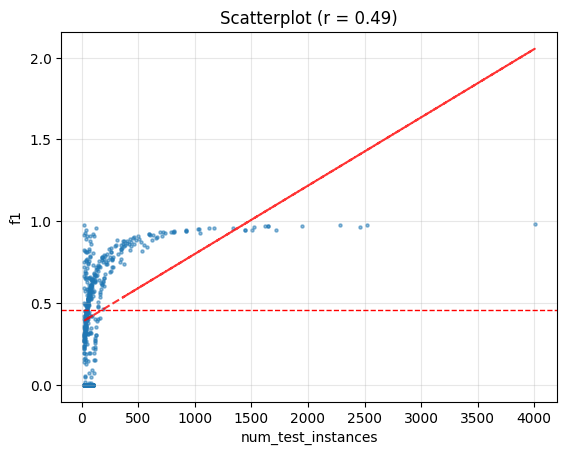

In [62]:
import matplotlib.pyplot as plt

def plot_scatter(df, x, y, title="Scatterplot"):
    correlation = np.corrcoef(df[x], df[y])[0,1]
    title = f"{title} (r = {correlation:.2f})"
    plt.scatter(df[x], df[y], s=5, alpha=0.5)
    # draw a line through the mean
    plt.axhline(df[y].mean(), color='red', linestyle='dashed', linewidth=1)
    z = np.polyfit(df[x], df[y], 1)
    p = np.poly1d(z)
    plt.plot(df[x], p(df[x]), "r--", alpha=0.8)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.savefig(results_dir / f"scatterplot-{x}-{y}.png")
    plt.show()
    
plot_scatter(df, "num_test_instances", "f1",)

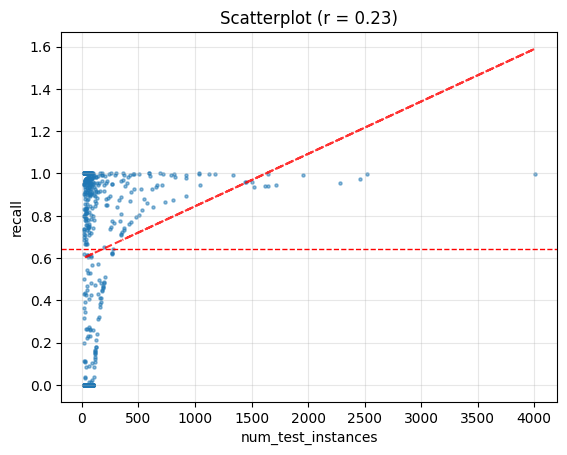

In [63]:
plot_scatter(df, "num_test_instances", "recall")


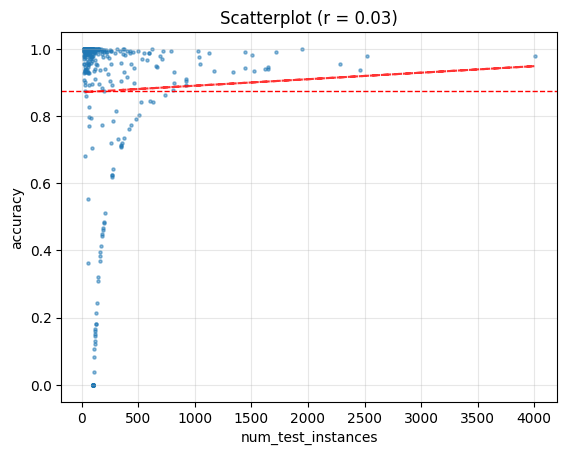

In [64]:
plot_scatter(df, "num_test_instances", "accuracy")

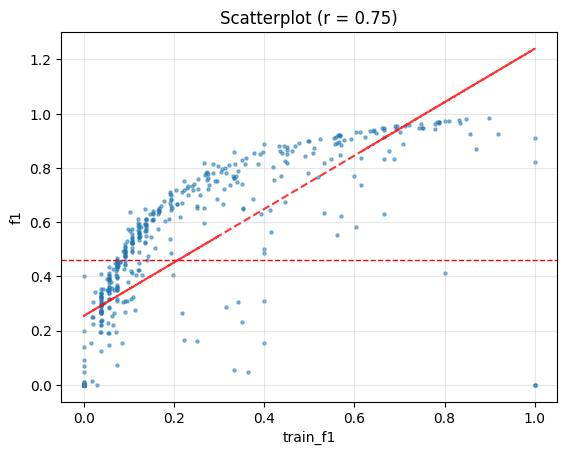

In [65]:
plot_scatter(df, "train_f1", "f1")


In [66]:
from c3p.stats import calculate_metrics_pandas


def micro_stats(df):
    df["f1_score"] = df["f1"]
    return df.select_dtypes(include=['int64', 'float64']).mean()

def macro_stats(df):
    return calculate_metrics_pandas(df)

def calculate_stats(df):
    sdf = pd.DataFrame(
        {
            'micro': micro_stats(df),
            'macro': macro_stats(df),
        },
    )
    sdf = sdf.transpose()
    return sdf[["f1_score", "precision", "recall", "accuracy"]]
    

calculate_stats(df)

,f1_score,precision,recall,accuracy
micro,0.459169,0.433254,0.641921,0.874217
macro,0.764500,0.712900,0.824100,0.998700


In [67]:
calculate_stats(df[df["num_test_instances"] > 100])

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_94662/3360052499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["f1_score"] = df["f1"]


,f1_score,precision,recall,accuracy
micro,0.741029,0.803804,0.780715,0.823249
macro,0.879300,0.861900,0.897500,0.994300


In [68]:
calculate_stats(df[df["num_test_instances"] > 150])

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_94662/3360052499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["f1_score"] = df["f1"]


,f1_score,precision,recall,accuracy
micro,0.82373,0.843147,0.84644,0.871803
macro,0.90240,0.886000,0.91940,0.992300


In [69]:
calculate_stats(df[(df["num_test_instances"] > 150) & (df["train_f1"] > 0.5)])

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_94662/3360052499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["f1_score"] = df["f1"]


,f1_score,precision,recall,accuracy
micro,0.89666,0.936425,0.882602,0.884353
macro,0.94100,0.938100,0.944000,0.992900


In [70]:
calculate_stats(df).to_csv(results_dir / "summary.csv")